## 02 - INITIAL DATA ANALYSIS

###### Lecture explaining xarray functionalities geospatial processing : datacubes_data_handling.ipynb

#### 02.1 - Libraries import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

In [3]:
# Open the file NetCDF

dataset2 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\era5-downscaled-over-italy_hourly_22209.nc")
dataset3 = xr.open_dataset(r"C:\Users\andre\OneDrive\Desktop\Datasets_Geoinfprj\era5-downscaled-over-italy_hourly_22223.nc")

In [4]:
###### PROVA CODICE NUOVO CHE CALCOLA FUNZIONI IN CELSIUS

def calculate_humidex(Ta_k, Td_k):
    """
    Calcola l'Humidex in °C usando la formula di Masterson/Chin.
    Parametri:
      - Ta_k: temperatura dell'aria in Kelvin
      - Td_k: temperatura di rugiada in Kelvin
    Ritorna:
      - Humidex in °C
    """
    # Conversione in °C
    Ta_c = Ta_k - 273.15
    Td_c = Td_k - 273.15

    # Evita valori troppo bassi per Td
    Td_c = np.maximum(Td_c, -73.15)  # ~200 K

    # Calcolo della pressione di vapore (e) in hPa
    exponent = 5417.7530 * ((1.0 / 273.16) - (1.0 / (Td_c + 273.16)))
    e = 6.11 * np.exp(exponent)

    # Formula Humidex
    humidex_c = Ta_c + 0.5555 * (e - 10.0)
    return humidex_c


def calculate_relative_humidity(Ta_c, Td_c):
    """
    Calcola l'umidità relativa in %,
    assumendo Ta_c e Td_c in °C.
    """
    RH = 100.0 * np.exp((17.625 * Td_c) / (243.04 + Td_c)
                        - (17.625 * Ta_c) / (243.04 + Ta_c))
    return RH


def calculate_heat_index(Ta_c, RH):
    """
    Calcola il Heat Index in °C, partendo da:
      - Ta_c: temperatura dell'aria in °C
      - RH: umidità relativa in %
    La formula originale è in °F, quindi:
      1) Converte Ta_c -> °F
      2) Calcola HI in °F
      3) Riconverte in °C
    """
    # °C -> °F
    Ta_f = Ta_c * 9.0 / 5.0 + 32.0

    HI_f = (-42.379
            + 2.04901523 * Ta_f
            + 10.14333127 * RH
            - 0.22475541 * Ta_f * RH
            - 6.8378e-3 * Ta_f**2
            - 5.48172e-2 * RH**2
            + 1.229e-3 * Ta_f**2 * RH
            + 8.528e-4 * Ta_f * RH**2
            - 1.99e-6 * Ta_f**2 * RH**2)

    # °F -> °C
    HI_c = (HI_f - 32.0) * 5.0 / 9.0
    return HI_c


def calculate_wbt(Ta_c, RH):
    """
    Calcola la Wet-Bulb Temperature (WBT) in °C (formula semplificata di Stull).
    Parametri:
      - Ta_c: temperatura in °C
      - RH: umidità relativa in %
    """
    WBT_c = (Ta_c * np.arctan(0.151977 * np.sqrt(RH + 8.313659))
             + np.arctan(Ta_c + RH)
             - np.arctan(RH - 1.676331)
             + 0.00391838 * RH**1.5 * np.arctan(0.023101 * RH)
             - 4.686035)
    return WBT_c


def calculate_wbgt(Ta_c, WBT_c):
    """
    Calcola WBGT in °C con la formula semplificata:
      WBGT = 0.7 * WBT + 0.3 * Ta
    Parametri:
      - Ta_c: temperatura in °C
      - WBT_c: Wet-Bulb Temperature in °C
    """
    WBGT_c = 0.7 * WBT_c + 0.3 * Ta_c
    return WBGT_c


def calculate_lethal_heat_stress_index(WBT_c, RH):
    """
    Calcola Lethal Heat Stress Index (Ls) in °C con la formula:
      Ls = WBT + 4.5 * (1 - (RH/100)^2)
    Parametri:
      - WBT_c: Wet-Bulb Temperature in °C
      - RH: umidità relativa in %
    """
    Ls_c = WBT_c + 4.5 * (1.0 - (RH / 100.0)**2)
    return Ls_c


def calculate_utci(Ta_c, RH):
    """
    Calcola una versione semplificata di UTCI in °C,
    Parametri:
      - Ta_c: temperatura in °C
      - RH: umidità relativa in %
    """
    # Pressione di vapore approssimata
    pa = RH / 100.0 * 6.105 * np.exp(17.27 * Ta_c / (237.7 + Ta_c))

    # Formula semplificata
    UTCI_c = (Ta_c
              + 0.607562
              + 0.022771 * Ta_c
              - 0.003578 * RH
              - 0.000119 * Ta_c * RH)
    return UTCI_c

#### Verifica sul singolo timestamp del superamento o meno di tutte le soglie di pericolosità

In [12]:
###### PROVA CODICE NUOVO CHE PRENDE FUNZIONI IN CELSIUS

# Seleziona un timestamp specifico
time_selected = dataset3['T_2M'].time[23471]

# Estrai temperatura e dew point temperature per il timestamp selezionato
temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)  # in Kelvin
dew_point_snapshot = dataset2['TD_2M'].sel(time=time_selected)   # in Kelvin

# Filtra valori anomali e interpoliamo dew point temperature
dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear') \
                                             .interpolate_na(dim='rlon', method='linear')


## CALCOLO DEGLI INDICI
# Calcolo Humidex (richiede Ta e Td in Kelvin)
humidex_snapshot = calculate_humidex(temperature_snapshot, dew_point_interpolated)

# Calcolo dell'Umidità Relativa in %
# Convertiamo T e Td in °C
relative_humidity_snapshot = calculate_relative_humidity(temperature_snapshot - 273.15, dew_point_interpolated - 273.15)

# Heat Index in °C (input: Ta in °C, RH in %)
heat_index_snapshot = calculate_heat_index(temperature_snapshot - 273.15, relative_humidity_snapshot)

# Wet-Bulb Temperature in °C (input: Ta in °C, RH in %)
wbt_snapshot = calculate_wbt(temperature_snapshot - 273.15, relative_humidity_snapshot)

# WBGT in °C (input: Ta in °C, WBT in °C)
wbgt_snapshot = calculate_wbgt(temperature_snapshot - 273.15, wbt_snapshot)

# Lethal Heat Stress Index in °C (input: WBT in °C, RH in %)
lhs_snapshot = calculate_lethal_heat_stress_index(wbt_snapshot, relative_humidity_snapshot)

# UTCI in °C (input: Ta in °C, RH in %)
utci_snapshot = calculate_utci(temperature_snapshot - 273.15, relative_humidity_snapshot)



# Calcola statistiche per ciascun indice
def calculate_stats(data_array):
    return {
        "mean": data_array.mean().item(),
        "median": data_array.median().item(),
        "p95": np.percentile(data_array, 95),
        "p99": np.percentile(data_array, 99),
        "max": data_array.max().item()
    }

# Dizionario degli indici calcolati
indices = {
    "Heat Index": heat_index_snapshot,
    "Humidex": humidex_snapshot,
    "Lethal Heat Stress Index": lhs_snapshot,
    "UTCI": utci_snapshot,
    "WBGT": wbgt_snapshot
}

# Statistiche
stats_results = {key: calculate_stats(value) for key, value in indices.items()}

# Definizione delle soglie per ciascun indice (in °C)
soglie = {
    "Heat Index": 40.6,
    "Humidex": 45,
    "Lethal Heat Stress Index": 27,
    "UTCI": 44,      # By literature is 46
    "WBGT": 28       # By literature is 30
}

# Creazione del DataFrame con i risultati
df_results = pd.DataFrame([
    {
        "Indice": key,
        "Media (°C)": value["mean"],
        "Mediana (°C)": value["median"],
        "95° Perc. (°C)": value["p95"],
        "99° Perc. (°C)": value["p99"],
        "Massimo (°C)": value["max"],
        "Soglia (°C)": soglie[key],
        "Media > Soglia": "si" if value["mean"] > soglie[key] else "no",
        "Mediana > Soglia": "si" if value["median"] > soglie[key] else "no",
        "95° Perc. > Soglia": "si" if value["p95"] > soglie[key] else "no",
        "99° Perc. > Soglia": "si" if value["p99"] > soglie[key] else "no",
        "Massimo > Soglia": "si" if value["max"] > soglie[key] else "no"
    }
    for key, value in stats_results.items()
])

# Ordina il DataFrame
df_results.sort_values(by="Indice", inplace=True)

# Funzione per colorare i "si" di rosso e i "no" di verde
def color_superamento(val):
    color = "red" if val == "si" else "green"
    return f"color: {color}"

# Applica la formattazione condizionale
df_styled = df_results.style.applymap(
    color_superamento,
    subset=["Media > Soglia", "Mediana > Soglia", "95° Perc. > Soglia", "99° Perc. > Soglia", "Massimo > Soglia"]
)

# Visualizza il DataFrame formattato con il timestamp in analisi
print(f"\n=== Confronto Indici vs Soglie per il timestamp selezionato ({str(time_selected.values)}) ===")
df_styled


=== Confronto Indici vs Soglie per il timestamp selezionato (2023-07-18T16:00:00.000000000) ===


,Indice,Media (°C),Mediana (°C),95° Perc. (°C),99° Perc. (°C),Massimo (°C),Soglia (°C),Media > Soglia,Mediana > Soglia,95° Perc. > Soglia,99° Perc. > Soglia,Massimo > Soglia
0,Heat Index,34.039677,34.453491,43.197288,44.121037,45.651348,40.600000,no,no,si,si,si
1,Humidex,35.540451,38.581848,46.374080,47.325891,48.856594,45.000000,no,no,si,si,si
2,Lethal Heat Stress Index,23.981258,25.636635,28.837666,29.773191,30.483885,27.000000,no,no,si,si,si
3,UTCI,34.030197,35.736885,44.696919,45.286666,46.082920,44.000000,no,no,si,si,si
4,WBGT,23.888197,25.768608,29.796879,30.335602,31.133190,28.000000,no,no,si,si,si


#### Criterias to identify heat waves

| Index | Threshold value by literature | Threshold value used |
|:--|:--|:--|
| Heat Index (HI) | > 105°F (~40.6°C) |
| Humidex (Hu) | > 45°C |
| WBGT | > 30°C | > 28°C |
| Lethal Heat Stress Index (Ls) | > 27°C |
| UTCI | > 46°C | > 44°C |


#### Verifica su tutti i timestamp di un anno del superamento o meno di tutte le soglie di pericolosità & selezione dei giorni consecutivi (almeno 3) in cui ciò accade -> heat wave vs casi isolati

In [10]:
import numpy as np
import pandas as pd
import xarray as xr

# ------------------ CONFIGURAZIONE ------------------
# Seleziona l'anno di analisi
year = 2023

# Definizione delle soglie per ciascun indice (in °C)
soglie = {
    "Heat Index": 40.6,
    "Humidex": 45,
    "Lethal Heat Stress Index": 27,
    "UTCI": 46,
    "WBGT": 30
}

# ------------------ PREPARAZIONE TIMESTAMPS GLOBALI ------------------
# Ottieni tutti i timestamp globali dal dataset come array NumPy (np.datetime64)
global_times = dataset3['T_2M'].time.values

# Converte i timestamp in un formato datetime (usando pd.to_datetime) e filtra per l'anno selezionato
selected_mask = pd.to_datetime(global_times).year == year
# Ottieni gli indici globali per i timestamp dell'anno selezionato
selected_indices = np.nonzero(selected_mask)[0]
# Seleziona i timestamp dell'anno in analisi come array NumPy
timestamps = global_times[selected_mask]

# Lista per salvare i risultati finali
heatwave_records = []

# ------------------ LOOP SUI TIMESTAMPS SELEZIONATI ------------------
for global_idx, time_selected in zip(selected_indices, timestamps):
    
    # Estrai temperatura e dew point per il timestamp attuale (dati in Kelvin)
    temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)
    dew_point_snapshot = dataset2['TD_2M'].sel(time=time_selected)
    
    # Filtra valori anomali e interpola il dew point
    dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
    dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear') \
                                                 .interpolate_na(dim='rlon', method='linear')
    
    # Calcola gli indici per ciascun pixel
    humidex_snapshot = calculate_humidex(temperature_snapshot, dew_point_interpolated)
    relative_humidity_snapshot = calculate_relative_humidity(
        temperature_snapshot - 273.15,
        dew_point_interpolated - 273.15
    )
    heat_index_snapshot = calculate_heat_index(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    wbt_snapshot = calculate_wbt(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    wbgt_snapshot = calculate_wbgt(
        temperature_snapshot - 273.15,
        wbt_snapshot
    )
    lhs_snapshot = calculate_lethal_heat_stress_index(
        wbt_snapshot,
        relative_humidity_snapshot
    )
    utci_snapshot = calculate_utci(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    
    # Calcola statistiche per ciascun indice
    def calculate_stats(data_array):
        return {
            "mean": data_array.mean().item(),
            "median": data_array.median().item(),
            "p95": np.percentile(data_array, 95),
            "p99": np.percentile(data_array, 99),
            "max": data_array.max().item()
        }
    
    indices = {
        "Heat Index": heat_index_snapshot,
        "Humidex": humidex_snapshot,
        "Lethal Heat Stress Index": lhs_snapshot,
        "UTCI": utci_snapshot,
        "WBGT": wbgt_snapshot
    }
    
    stats_results = {key: calculate_stats(value) for key, value in indices.items()}
    
    # Verifica se TUTTI gli indici superano la soglia in almeno una delle statistiche
    all_exceed = all(
        any([
            stats_results[key]["mean"] > soglie[key],
            stats_results[key]["median"] > soglie[key],
            stats_results[key]["p95"] > soglie[key],
            stats_results[key]["p99"] > soglie[key],
            stats_results[key]["max"] > soglie[key]
        ])
        for key in indices.keys()
    )
    
    # Se la condizione è soddisfatta, salva il risultato
    if all_exceed:
        df_results = pd.DataFrame([
            {
                "Indice": key,
                "Media (°C)": value["mean"],
                "Mediana (°C)": value["median"],
                "95° Perc. (°C)": value["p95"],
                "99° Perc. (°C)": value["p99"],
                "Massimo (°C)": value["max"],
                "Soglia (°C)": soglie[key],
                "Media > Soglia": "si" if value["mean"] > soglie[key] else "no",
                "Mediana > Soglia": "si" if value["median"] > soglie[key] else "no",
                "95° Perc. > Soglia": "si" if value["p95"] > soglie[key] else "no",
                "99° Perc. > Soglia": "si" if value["p99"] > soglie[key] else "no",
                "Massimo > Soglia": "si" if value["max"] > soglie[key] else "no"
            }
            for key, value in stats_results.items()
        ])
        
        # Aggiungi il timestamp e il numero globale (a partire da 1) per il record
        df_results.insert(0, "Timestamp", str(time_selected))
        df_results.insert(1, "Numero Timestamp", global_idx + 1)
        
        heatwave_records.extend(df_results.to_dict(orient="records"))

# ------------------ COSTRUZIONE DEL DATAFRAME FINALE ------------------
df_heatwave = pd.DataFrame(heatwave_records)

# Identificazione di heat wave: almeno 3 giorni consecutivi
df_heatwave["Data"] = pd.to_datetime(df_heatwave["Timestamp"]).dt.date
df_heatwave["Heat Wave"] = "caso isolato"

for i, row in df_heatwave.iterrows():
    current_date = row["Data"]
    
    # Calcola i giorni adiacenti
    next_day1 = current_date + pd.Timedelta(days=1)
    next_day2 = current_date + pd.Timedelta(days=2)
    prev_day1 = current_date - pd.Timedelta(days=1)
    prev_day2 = current_date - pd.Timedelta(days=2)
    
    # Se esiste un blocco di almeno 3 giorni consecutivi che include current_date
    if (
        (next_day1 in df_heatwave["Data"].values and next_day2 in df_heatwave["Data"].values)
        or (prev_day1 in df_heatwave["Data"].values and next_day1 in df_heatwave["Data"].values)
        or (prev_day1 in df_heatwave["Data"].values and prev_day2 in df_heatwave["Data"].values)
    ):
        df_heatwave.at[i, "Heat Wave"] = "heat wave"

# Salva il DataFrame finale su file CSV
df_heatwave.to_csv(f"heatwave_timestamps_{year}.csv", index=False)

# Messaggio di controllo
print(f"\n=== Giorni con Ondate di Calore Estreme (≥3 giorni consecutivi) nel {year} ===")
if df_heatwave.empty:
    print("Nessun giorno dell'anno selezionato ha superato tutte le soglie di pericolosità per il caldo estremo.")
else:
    print("Stampa nella cella successiva df_heatwave per vederlo in formato DataFrame.")


=== Giorni con Ondate di Calore Estreme (≥3 giorni consecutivi) nel 2023 ===
Stampa nella cella successiva df_heatwave per vederlo in formato DataFrame.


In [11]:
df_heatwave

,Timestamp,Numero Timestamp,Indice,Media (°C),Mediana (°C),95° Perc. (°C),99° Perc. (°C),Massimo (°C),Soglia (°C),Media > Soglia,Mediana > Soglia,95° Perc. > Soglia,99° Perc. > Soglia,Massimo > Soglia,Data,Heat Wave
0,2023-07-17T15:00:00.000000000,23465,Heat Index,33.828320,34.416645,41.746232,42.626288,44.100754,40.6,no,no,si,si,si,2023-07-17,heat wave
1,2023-07-17T15:00:00.000000000,23465,Humidex,35.140137,38.019917,44.736756,45.632275,47.165943,45.0,no,no,no,si,si,2023-07-17,heat wave
2,2023-07-17T15:00:00.000000000,23465,Lethal Heat Stress Index,23.345772,24.783621,27.674836,28.116030,29.107450,27.0,no,no,si,si,si,2023-07-17,heat wave
3,2023-07-17T15:00:00.000000000,23465,UTCI,34.943035,36.611519,44.443080,45.058379,46.140484,46.0,no,no,no,no,si,2023-07-17,heat wave
4,2023-07-17T15:00:00.000000000,23465,WBGT,23.572853,25.402393,28.850945,29.354012,30.173292,30.0,no,no,no,no,si,2023-07-17,heat wave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-08-24T15:00:00.000000000,23693,Heat Index,35.114590,36.715103,43.191731,43.899732,45.419678,40.6,no,no,si,si,si,2023-08-24,heat wave
76,2023-08-24T15:00:00.000000000,23693,Humidex,36.770340,40.270149,46.308254,47.057038,48.507965,45.0,no,no,si,si,si,2023-08-24,heat wave
77,2023-08-24T15:00:00.000000000,23693,Lethal Heat Stress Index,24.336843,25.970181,28.477583,29.151492,30.274513,27.0,no,no,si,si,si,2023-08-24,heat wave
78,2023-08-24T15:00:00.000000000,23693,UTCI,35.746422,38.889511,44.772475,45.336684,46.007748,46.0,no,no,no,no,si,2023-08-24,heat wave


#### GIF rappresentante il periodo prima durante e dopo la heat wave (senza mask di classificazione dei pixels)

In [33]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Evita il warning di ImageIO
import os

# **Parametri personalizzabili**
year = 2023  # Anno di analisi
target_timestamp_index = 286  # Numero del timestamp di riferimento (cambiabile dall'utente)
days_before = 10  # Giorni precedenti da mostrare
days_after = 12  # Giorni successivi da mostrare
indice_selezionato = "Heat Index"  # Indice da visualizzare nella mappa

# **Caricamento dei dati**
timestamps = dataset3['T_2M'].time.sel(time=dataset3['T_2M'].time.dt.year == year)
df_heatwave["Data"] = pd.to_datetime(df_heatwave["Timestamp"]).dt.date
heatwave_days = df_heatwave[df_heatwave['Heat Wave'] == 'heat wave']['Data'].unique()
heatwave_dates = set(str(date) for date in heatwave_days)  # Set di date formattate

# **Seleziona il timestamp di riferimento**
target_time = timestamps[target_timestamp_index]

# **Definiamo l'intervallo temporale per la GIF**
start_time = target_time - np.timedelta64(days_before, 'D')
end_time = target_time + np.timedelta64(days_after, 'D')
time_range = timestamps.sel(time=(timestamps >= start_time) & (timestamps <= end_time))

# **Calcola il range fisso per la legenda solo sui timestamp selezionati**
heat_index_values = []
for time_selected in time_range:
    temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)
    dew_point_snapshot = dataset2['TD_2M'].sel(time=time_selected)
    dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
    dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear').interpolate_na(dim='rlon', method='linear')
    heat_index_snapshot = calculate_heat_index(temperature_snapshot - 273.15, calculate_relative_humidity(temperature_snapshot - 273.15, dew_point_interpolated - 273.15))
    heat_index_values.append(heat_index_snapshot.values)

heat_index_values = np.concatenate([hi.flatten() for hi in heat_index_values])
heat_index_min = heat_index_values.min()
heat_index_max = heat_index_values.max()

# **Creazione di una cartella temporanea per le immagini**
output_folder = "temp_frames"
os.makedirs(output_folder, exist_ok=True)

# **Genera i frame per la GIF**
frames = []
for time_selected in time_range:
    
    # **Estrai i dati di temperatura e dew point**
    temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)
    dew_point_snapshot = dataset2['TD_2M'].sel(time=time_selected)
    
    # **Filtra valori anomali e interpoliamo dew point temperature**
    dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
    dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear').interpolate_na(dim='rlon', method='linear')
    
    # **Calcola gli indici**
    heat_index_snapshot = calculate_heat_index(temperature_snapshot - 273.15, calculate_relative_humidity(temperature_snapshot - 273.15, dew_point_interpolated - 273.15))
    
    # **Plotta la distribuzione dell'Heat Index per il timestamp corrente**
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(heat_index_snapshot, cmap="inferno", origin="lower", vmin=heat_index_min, vmax=heat_index_max)
    
    # **Legenda fissa**
    cbar = plt.colorbar(im, label="Heat Index (°C)")
    cbar.ax.tick_params(labelsize=10)
    
    # **Aggiungi il titolo con il timestamp e indicazione della heatwave**
    timestamp_str = str(time_selected.values)[:16]
    ax.set_title(timestamp_str, fontsize=14, fontweight="bold", ha='left', x=0)
    
    # **Se il giorno è una heatwave, evidenzia il riquadro e mostra la scritta**
    date_str = timestamp_str[:10]  # Estrai solo la parte di data
    if date_str in heatwave_dates:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
        ax.text(0.5, -0.1, "HEAT WAVE HIT", fontsize=18, color='red', ha='center', transform=ax.transAxes, fontweight='bold')
    
    # **Sostituisci i caratteri speciali per evitare errori nei nomi dei file**
    safe_timestamp = timestamp_str.replace(":", "-").replace("T", "_").split(".")[0]
    frame_filename = os.path.join(output_folder, f"frame_{safe_timestamp}.png")

    # **Salva il frame temporaneo**
    plt.savefig(frame_filename, dpi=100)
    plt.close()
    
    frames.append(frame_filename)

# **Creazione della GIF**
gif_filename = f"heatwave_evolution_{year}.gif"
with imageio.get_writer(gif_filename, mode='I', duration=5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# **Pulizia della cartella temporanea**
for frame in frames:
    try:
        os.remove(frame)
    except PermissionError:
        pass  # Ignora errori se il file è ancora in uso
try:
    os.rmdir(output_folder)
except PermissionError:
    pass  # Ignora errori se la cartella è ancora in uso

print(f"\n GIF creata con successo: {gif_filename}")


 GIF creata con successo: heatwave_evolution_2023.gif


#### GIF con selezione dei pixels (mask) che superano un determinato numero di parametri

In [39]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Per evitare warning
import os

# ------------------ PARAMETRI PERSONALIZZABILI ------------------
target_timestamp_index = 23472                        # indice globale
timestamps = dataset3['T_2M'].time.values             # usa tutti i timestamp
days_before = 10                                      # Giorni precedenti da mostrare
days_after = 12                                       # Giorni successivi da mostrare
indice_selezionato = "Humidex"       # Indice da visualizzare nella mappa
num_thresholds_needed = 3                             # Numero di indici che devono superare la soglia (pixel critici)

# Soglie per ciascun indice (in °C)
soglie = {
    "Heat Index": 40.6,
    "Humidex": 45,
    "Lethal Heat Stress Index": 27,
    "UTCI": 46,
    "WBGT": 30
}

# ------------------ PREPARAZIONE DEI TIMESTAMP ------------------
# Recupera il set di date delle heat wave (assicurati di aver creato df_heatwave in precedenza)
df_heatwave["Data"] = pd.to_datetime(df_heatwave["Timestamp"]).dt.date
heatwave_days = df_heatwave[df_heatwave['Heat Wave'] == 'heat wave']['Data'].unique()
heatwave_dates = set(str(date) for date in heatwave_days)  # Date formattate in stringa

# Seleziona il timestamp di riferimento
target_time = timestamps[target_timestamp_index]

# Definisci l'intervallo temporale per la GIF
start_time = target_time - np.timedelta64(days_before, 'D')
end_time   = target_time + np.timedelta64(days_after, 'D')
time_range = timestamps[(timestamps >= start_time) & (timestamps <= end_time)]

# ------------------ CALCOLO DEL RANGE PER LA LEGENDA ------------------
# Calcola il range fisso (vmin, vmax) in base all'indice selezionato
index_values_list = []
for time_sel in time_range:
    temp_snap = dataset3['T_2M'].sel(time=time_sel)
    dew_snap  = dataset2['TD_2M'].sel(time=time_sel)
    dew_filt  = dew_snap.where(dew_snap > 243.15)
    dew_interp = dew_filt.interpolate_na(dim='rlat', method='linear') \
                         .interpolate_na(dim='rlon', method='linear')
    RH = calculate_relative_humidity(temp_snap - 273.15, dew_interp - 273.15)
    
    # Calcola tutti gli indici
    heat_index_snap = calculate_heat_index(temp_snap - 273.15, RH)
    humidex_snap    = calculate_humidex(temp_snap, dew_interp)
    wbt_snap        = calculate_wbt(temp_snap - 273.15, RH)
    wbgt_snap       = calculate_wbgt(temp_snap - 273.15, wbt_snap)
    lhs_snap        = calculate_lethal_heat_stress_index(wbt_snap, RH)
    utci_snap       = calculate_utci(temp_snap - 273.15, RH)
    
    # Seleziona l'array in base all'indice scelto
    if indice_selezionato == "Heat Index":
        data = heat_index_snap.values
    elif indice_selezionato == "Humidex":
        data = humidex_snap.values
    elif indice_selezionato == "Lethal Heat Stress Index":
        data = lhs_snap.values
    elif indice_selezionato == "UTCI":
        data = utci_snap.values
    elif indice_selezionato == "WBGT":
        data = wbgt_snap.values
    else:
        raise ValueError("Indice selezionato non riconosciuto.")
    
    index_values_list.append(data.flatten())

index_values = np.concatenate(index_values_list)
indice_min = index_values.min()
indice_max = index_values.max()

# ------------------ GENERAZIONE DEI FRAME E CREAZIONE DELLA GIF ------------------
output_folder = "temp_frames"
os.makedirs(output_folder, exist_ok=True)

frames = []
for time_sel in time_range:
    # Recupera l'indice globale relativo all'anno
    global_idx = int(np.where(timestamps == time_sel)[0][0])
    
    # Estrai i dati di temperatura e dew point
    temp_snap = dataset3['T_2M'].sel(time=time_sel)
    dew_snap  = dataset2['TD_2M'].sel(time=time_sel)
    dew_filt  = dew_snap.where(dew_snap > 243.15)
    dew_interp = dew_filt.interpolate_na(dim='rlat', method='linear') \
                         .interpolate_na(dim='rlon', method='linear')
    RH = calculate_relative_humidity(temp_snap - 273.15, dew_interp - 273.15)
    
    # Calcola tutti gli indici
    heat_index_snap = calculate_heat_index(temp_snap - 273.15, RH)
    humidex_snap    = calculate_humidex(temp_snap, dew_interp)
    wbt_snap        = calculate_wbt(temp_snap - 273.15, RH)
    wbgt_snap       = calculate_wbgt(temp_snap - 273.15, wbt_snap)
    lhs_snap        = calculate_lethal_heat_stress_index(wbt_snap, RH)
    utci_snap       = calculate_utci(temp_snap - 273.15, RH)
    
    # Calcola la maschera pixel-by-pixel (per il contorno blu)
    mask_pixel = (
        ((heat_index_snap > soglie["Heat Index"]).astype(int) +
         (humidex_snap    > soglie["Humidex"]).astype(int) +
         (lhs_snap        > soglie["Lethal Heat Stress Index"]).astype(int) +
         (utci_snap       > soglie["UTCI"]).astype(int) +
         (wbgt_snap       > soglie["WBGT"]).astype(int))
        >= num_thresholds_needed
    )
    
    # Seleziona l'array dell'indice da visualizzare
    if indice_selezionato == "Heat Index":
        indice_data = heat_index_snap.values
    elif indice_selezionato == "Humidex":
        indice_data = humidex_snap.values
    elif indice_selezionato == "Lethal Heat Stress Index":
        indice_data = lhs_snap.values
    elif indice_selezionato == "UTCI":
        indice_data = utci_snap.values
    elif indice_selezionato == "WBGT":
        indice_data = wbgt_snap.values
    
    # Crea il plot per il frame corrente
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(indice_data, cmap="inferno", origin="lower",
                   vmin=indice_min, vmax=indice_max)
    cbar = plt.colorbar(im, ax=ax, label=f"{indice_selezionato} (°C)")
    cbar.ax.tick_params(labelsize=10)
    
    timestamp_str = str(time_sel)[:16]  # Es. '2023-07-15T12:34'
    ax.set_title(f"{timestamp_str}\nNumero Timestamp (globale): {global_idx + 1}",
                 fontsize=14, fontweight="bold", ha='left', x=0)
    
    # Controlla se il giorno corrente (estratto dal timestamp) fa parte della heat wave
    date_str = timestamp_str[:10]  # Es. '2023-07-15'
    if date_str in heatwave_dates:
        # Aggiunge il bordo rosso e la scritta "HEAT WAVE HIT"
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
        ax.text(0.5, -0.1, "HEAT WAVE HIT", fontsize=18, color='red',
                ha='center', transform=ax.transAxes, fontweight='bold')
    
    # Sovrapponi il contorno blu per i pixel “critici”
    ax.contour(mask_pixel.astype(float), levels=[0.5], colors='blue', linewidths=2)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    # Salva il frame con un nome “sicuro”
    safe_timestamp = timestamp_str.replace(":", "-").replace("T", "_").split(".")[0]
    frame_filename = os.path.join(output_folder, f"frame_{safe_timestamp}.png")
    plt.savefig(frame_filename, dpi=100)
    plt.close()
    
    frames.append(frame_filename)

# Creazione della GIF
gif_filename = f"heatwave_evolution_{year}_masked_{indice_selezionato}.gif"
with imageio.get_writer(gif_filename, mode='I', duration=5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

# Pulizia della cartella temporanea
for frame in frames:
    try:
        os.remove(frame)
    except PermissionError:
        pass
try:
    os.rmdir(output_folder)
except PermissionError:
    pass

print(f"\nGIF creata con successo: {gif_filename}")


GIF creata con successo: heatwave_evolution_2023_masked_Humidex.gif


#### Individuazione spaziale di dove avviene il superamento di tutti gli indici

Numero di pixel che superano almeno 3 soglie: 1486


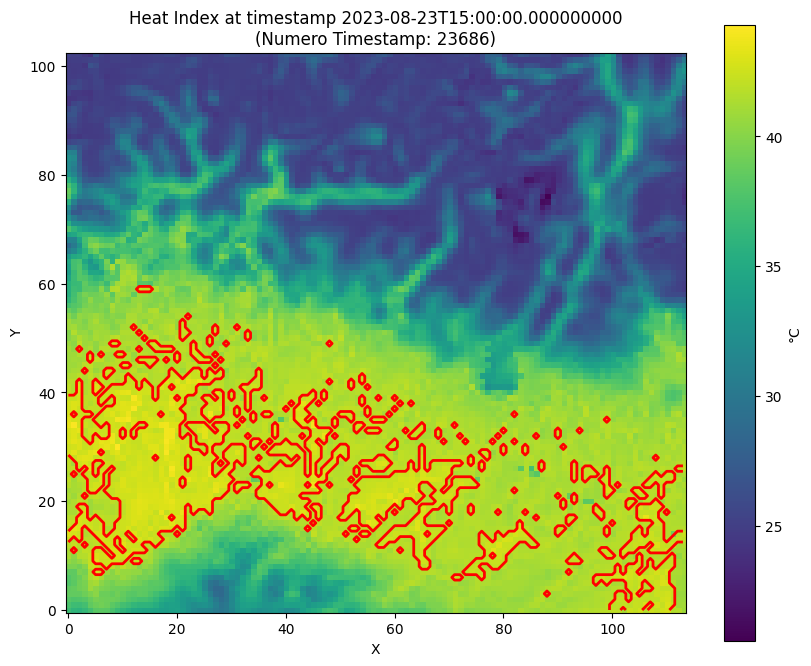

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Esempio di soglie
soglie = {
    "Heat Index": 40.6,
    "Humidex": 45,
    "Lethal Heat Stress Index": 27,
    "UTCI": 46,
    "WBGT": 30
}

# Seleziona il timestamp da analizzare (può essere un np.datetime64 o un indice)
timestamp_idx = 23686  # esempio
time_selected = dataset3['T_2M'].time[timestamp_idx]

# Estrai i campi di temperatura e dew point in Kelvin
temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)
dew_point_snapshot   = dataset2['TD_2M'].sel(time=time_selected)

# Filtra valori anomali e interpola
dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear') \
                                             .interpolate_na(dim='rlon', method='linear')

# Calcolo dei campi (in °C) dei vari indici
RH_field = calculate_relative_humidity(temperature_snapshot - 273.15,
                                       dew_point_interpolated - 273.15)

heat_index_field = calculate_heat_index(temperature_snapshot - 273.15, RH_field)
humidex_field    = calculate_humidex(temperature_snapshot, dew_point_interpolated)
wbt_field        = calculate_wbt(temperature_snapshot - 273.15, RH_field)
wbgt_field       = calculate_wbgt(temperature_snapshot - 273.15, wbt_field)
lhs_field        = calculate_lethal_heat_stress_index(wbt_field, RH_field)
utci_field       = calculate_utci(temperature_snapshot - 273.15, RH_field)

# Crea un array "exceed_count" che per ogni pixel conta quante soglie sono superate
exceed_count = (
    (heat_index_field > soglie["Heat Index"]).astype(int) +
    (humidex_field    > soglie["Humidex"]).astype(int) +
    (lhs_field        > soglie["Lethal Heat Stress Index"]).astype(int) +
    (utci_field       > soglie["UTCI"]).astype(int) +
    (wbgt_field       > soglie["WBGT"]).astype(int)
)

# Maschera booleana: True se si superano almeno 3 soglie
mask = exceed_count >= 3

# Conta i pixel che soddisfano la condizione
mask_sum = mask.sum().item()
print(f"Numero di pixel che superano almeno 3 soglie: {mask_sum}")

# Scegli un indice da visualizzare in mappa (ad es. Heat Index)
selected_index = "Heat Index"
index_data = heat_index_field.values  # in °C

# Plot
plt.figure(figsize=(10,8))
plt.imshow(index_data, origin='lower', cmap='viridis')
plt.title(f"{selected_index} at timestamp {str(time_selected.values)}\n(Indice globale del Timestamp: {timestamp_idx})")
plt.colorbar(label="°C")

# Disegno del contorno rosso dove mask = True
plt.contour(mask.astype(float), levels=[0.5], colors='red', linewidths=2)

plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#### Ricerca di tutte le heatwaves presenti nel dataset senza caso isolato

In [25]:
# Il CSV finale verrà salvato con un nome che indica che sono stati analizzati tutti gli anni disponibili.
output_csv = "heatwave_timestamps_all.csv"

# Definizione delle soglie per ciascun indice (in °C)
soglie = {
    "Heat Index": 40.6,
    "Humidex": 45,
    "Lethal Heat Stress Index": 27,
    "UTCI": 46,
    "WBGT": 30
}

# Lista per salvare i risultati finali
heatwave_records = []

# Estrai TUTTI i timestamp (tutti gli anni) dal dataset
timestamps = dataset3['T_2M'].time

# --- LOOP PER OGNI TIMESTAMP ---
for i, time_selected in enumerate(timestamps):
    
    # Estrai temperatura e dew point per il timestamp attuale (dati in Kelvin)
    temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)
    dew_point_snapshot = dataset2['TD_2M'].sel(time=time_selected)
    
    # Filtra valori anomali e interpola il dew point
    dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
    dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear') \
                                                 .interpolate_na(dim='rlon', method='linear')

    # Calcola gli indici per ciascun pixel.
    # Le funzioni (calculate_humidex, calculate_relative_humidity, ecc.) gestiscono internamente le conversioni
    humidex_snapshot = calculate_humidex(temperature_snapshot, dew_point_interpolated)
    relative_humidity_snapshot = calculate_relative_humidity(
        temperature_snapshot - 273.15,
        dew_point_interpolated - 273.15
    )
    heat_index_snapshot = calculate_heat_index(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    wbt_snapshot = calculate_wbt(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    wbgt_snapshot = calculate_wbgt(
        temperature_snapshot - 273.15,
        wbt_snapshot
    )
    lhs_snapshot = calculate_lethal_heat_stress_index(
        wbt_snapshot,
        relative_humidity_snapshot
    )
    utci_snapshot = calculate_utci(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )

    # Calcola statistiche per ciascun indice
    def calculate_stats(data_array):
        return {
            "mean": data_array.mean().item(),
            "median": data_array.median().item(),
            "p95": np.percentile(data_array, 95),
            "p99": np.percentile(data_array, 99),
            "max": data_array.max().item()
        }

    indices = {
        "Heat Index": heat_index_snapshot,
        "Humidex": humidex_snapshot,
        "Lethal Heat Stress Index": lhs_snapshot,
        "UTCI": utci_snapshot,
        "WBGT": wbgt_snapshot
    }

    stats_results = {key: calculate_stats(value) for key, value in indices.items()}

    # Verifica se TUTTI gli indici superano la soglia in almeno una delle statistiche
    all_exceed = all(
        any([
            stats_results[key]["mean"] > soglie[key],
            stats_results[key]["median"] > soglie[key],
            stats_results[key]["p95"] > soglie[key],
            stats_results[key]["p99"] > soglie[key],
            stats_results[key]["max"] > soglie[key]
        ])
        for key in indices.keys()
    )

    # Se la condizione è soddisfatta, salva il risultato in un DataFrame temporaneo
    if all_exceed:
        df_results = pd.DataFrame([
            {
                "Indice": key,
                "Media (°C)": value["mean"],
                "Mediana (°C)": value["median"],
                "95° Perc. (°C)": value["p95"],
                "99° Perc. (°C)": value["p99"],
                "Massimo (°C)": value["max"],
                "Soglia (°C)": soglie[key],
                "Media > Soglia": "si" if value["mean"] > soglie[key] else "no",
                "Mediana > Soglia": "si" if value["median"] > soglie[key] else "no",
                "95° Perc. > Soglia": "si" if value["p95"] > soglie[key] else "no",
                "99° Perc. > Soglia": "si" if value["p99"] > soglie[key] else "no",
                "Massimo > Soglia": "si" if value["max"] > soglie[key] else "no"
            }
            for key, value in stats_results.items()
        ])
        
        # Aggiungi il timestamp (e l'indice del timestamp) per tracciare i record
        df_results.insert(0, "Timestamp", str(time_selected.values))
        df_results.insert(1, "Numero Timestamp", i)
        
        # Estendi la lista dei record
        heatwave_records.extend(df_results.to_dict(orient="records"))

# Creazione del DataFrame finale con tutti i record
df_heatwave = pd.DataFrame(heatwave_records)

# --- IDENTIFICAZIONE DI HEAT WAVES (3 giorni consecutivi) ---
# Aggiungi una colonna "Data" (solo data, senza ora)
df_heatwave["Data"] = pd.to_datetime(df_heatwave["Timestamp"]).dt.date

# Imposta inizialmente l'etichetta "Heat Wave" a "caso isolato"
df_heatwave["Heat Wave"] = "caso isolato"

# Per ogni record, controlla se esiste un blocco di almeno 3 giorni consecutivi
for i, row in df_heatwave.iterrows():
    current_date = row["Data"]

    # Giorni adiacenti
    next_day1 = current_date + pd.Timedelta(days=1)
    next_day2 = current_date + pd.Timedelta(days=2)
    prev_day1 = current_date - pd.Timedelta(days=1)
    prev_day2 = current_date - pd.Timedelta(days=2)

    # Se esiste un blocco di almeno 3 giorni consecutivi che include current_date:
    # ad esempio (D, D+1, D+2) oppure (D-1, D, D+1) oppure (D-2, D-1, D)
    if (
        (next_day1 in df_heatwave["Data"].values and next_day2 in df_heatwave["Data"].values)
        or (prev_day1 in df_heatwave["Data"].values and next_day1 in df_heatwave["Data"].values)
        or (prev_day1 in df_heatwave["Data"].values and prev_day2 in df_heatwave["Data"].values)
    ):
        df_heatwave.at[i, "Heat Wave"] = "heat wave"

# Salva il DataFrame finale su file CSV
df_heatwave.to_csv(output_csv, index=False)

# Messaggio di controllo
print(f"\n=== Giorni con Ondate di Calore Estreme (≥3 giorni consecutivi) in tutti gli anni ===")
if df_heatwave.empty:
    print("Nessun giorno del dataset ha superato tutte le soglie di pericolosità per il caldo estremo.")
else:
    print("Il file CSV è stato creato: ", output_csv)


=== Giorni con Ondate di Calore Estreme (≥3 giorni consecutivi) in tutti gli anni ===
Il file CSV è stato creato:  heatwave_timestamps_all.csv


#### Ricerca di tutte le heatwaves presenti nel dataset con caso isolato

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

# ------------------ CONFIGURAZIONE ------------------
# Definizione delle soglie per ciascun indice (in °C)
soglie = {
    "Heat Index": 40.6,
    "Humidex": 45,
    "Lethal Heat Stress Index": 27,
    "UTCI": 46,
    "WBGT": 30
}

# Lista per salvare i record finali (sia heat wave che casi isolati)
heatwave_records = []

# Estrai TUTTI i timestamp dal dataset (tutti gli anni)
timestamps = dataset3['T_2M'].time.values

# ------------------ LOOP PER OGNI TIMESTAMP ------------------
for i, time_selected in enumerate(timestamps):
    # Estrai i dati di temperatura e dew point (in Kelvin)
    temperature_snapshot = dataset3['T_2M'].sel(time=time_selected)
    dew_point_snapshot = dataset2['TD_2M'].sel(time=time_selected)
    
    # Filtra valori anomali e interpola il dew point
    dew_point_filtered = dew_point_snapshot.where(dew_point_snapshot > 243.15)
    dew_point_interpolated = dew_point_filtered.interpolate_na(dim='rlat', method='linear') \
                                                 .interpolate_na(dim='rlon', method='linear')
    
    # Calcola gli indici
    humidex_snapshot = calculate_humidex(temperature_snapshot, dew_point_interpolated)
    relative_humidity_snapshot = calculate_relative_humidity(
        temperature_snapshot - 273.15,
        dew_point_interpolated - 273.15
    )
    heat_index_snapshot = calculate_heat_index(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    wbt_snapshot = calculate_wbt(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    wbgt_snapshot = calculate_wbgt(
        temperature_snapshot - 273.15,
        wbt_snapshot
    )
    lhs_snapshot = calculate_lethal_heat_stress_index(
        wbt_snapshot,
        relative_humidity_snapshot
    )
    utci_snapshot = calculate_utci(
        temperature_snapshot - 273.15,
        relative_humidity_snapshot
    )
    
    # Funzione per calcolare le statistiche (media, mediana, 95°perc, 99°perc, massimo)
    def calculate_stats(data_array):
        return {
            "mean": data_array.mean().item(),
            "median": data_array.median().item(),
            "p95": np.percentile(data_array, 95),
            "p99": np.percentile(data_array, 99),
            "max": data_array.max().item()
        }
    
    # Dizionario degli indici (ogni indice è un DataArray)
    indices = {
        "Heat Index": heat_index_snapshot,
        "Humidex": humidex_snapshot,
        "Lethal Heat Stress Index": lhs_snapshot,
        "UTCI": utci_snapshot,
        "WBGT": wbgt_snapshot
    }
    
    # Calcola le statistiche per ciascun indice
    stats_results = {key: calculate_stats(value) for key, value in indices.items()}
    
    # Verifica se per **ogni indice** almeno una delle statistiche supera la soglia corrispondente
    all_exceed = all(
        any([
            stats_results[key]["mean"] > soglie[key],
            stats_results[key]["median"] > soglie[key],
            stats_results[key]["p95"] > soglie[key],
            stats_results[key]["p99"] > soglie[key],
            stats_results[key]["max"] > soglie[key]
        ])
        for key in indices.keys()
    )
    
    # Se la condizione è soddisfatta, registra il risultato (per ogni indice)
    if all_exceed:
        df_results = pd.DataFrame([
            {
                "Indice": key,
                "Media (°C)": value["mean"],
                "Mediana (°C)": value["median"],
                "95° Perc. (°C)": value["p95"],
                "99° Perc. (°C)": value["p99"],
                "Massimo (°C)": value["max"],
                "Soglia (°C)": soglie[key],
                "Media > Soglia": "si" if value["mean"] > soglie[key] else "no",
                "Mediana > Soglia": "si" if value["median"] > soglie[key] else "no",
                "95° Perc. > Soglia": "si" if value["p95"] > soglie[key] else "no",
                "99° Perc. > Soglia": "si" if value["p99"] > soglie[key] else "no",
                "Massimo > Soglia": "si" if value["max"] > soglie[key] else "no"
            }
            for key, value in stats_results.items()
        ])
        # Aggiungi il timestamp (completo) e il numero globale (a partire da 1)
        df_results.insert(0, "Timestamp", str(time_selected))
        df_results.insert(1, "Numero Timestamp", i + 1)
        heatwave_records.extend(df_results.to_dict(orient="records"))

# ------------------ COSTRUZIONE DEL DATAFRAME FINALE ------------------
df_heatwave = pd.DataFrame(heatwave_records)

# Aggiungi una colonna "Data" che contiene solo la parte della data (senza l'orario)
df_heatwave["Data"] = pd.to_datetime(df_heatwave["Timestamp"]).dt.date

# Inizialmente etichetta ogni record come "caso isolato"
df_heatwave["Heat Wave"] = "caso isolato"

# ------------------ IDENTIFICAZIONE DI HEAT WAVES (≥ 3 giorni consecutivi) ------------------
# Individua i giorni unici presenti nei record
unique_dates = sorted(df_heatwave["Data"].unique())

# Costruisci un insieme di date che fanno parte di blocchi consecutivi di almeno 3 giorni
consecutive_dates = set()
for d in unique_dates:
    if (d + pd.Timedelta(days=1) in unique_dates) and (d + pd.Timedelta(days=2) in unique_dates):
        consecutive_dates.add(d)
        consecutive_dates.add(d + pd.Timedelta(days=1))
        consecutive_dates.add(d + pd.Timedelta(days=2))

# Aggiorna il DataFrame: se la data del record è in consecutive_dates, etichettalo come "heat wave"
df_heatwave.loc[df_heatwave["Data"].isin(consecutive_dates), "Heat Wave"] = "heat wave"

# Salva il DataFrame finale su file CSV
output_csv = "heatwave_timestamps_all.csv"
df_heatwave.to_csv(output_csv, index=False)

print(f"\nFile CSV creato: {output_csv}")

#### Lista di tutti i timestamps numerati

In [22]:
# Estrai i valori di time come array NumPy di timestamp (np.datetime64)
global_times = dataset3['T_2M'].time.values

records = []
for i, ts in enumerate(global_times):
    # Converte np.datetime64 in oggetto datetime di pandas
    dt = pd.to_datetime(ts)
    # Ricava data e ora come stringhe
    date_str = dt.strftime('%Y-%m-%d')  # es. '2023-07-18'
    hour_str = dt.strftime('%H:%M:%S')  # es. '16:00:00'
    
    records.append({
        "Data": date_str,
        "Ora": hour_str,
        "Numero Timestamp": i + 1  # parte da 1
    })

# Crea un DataFrame con le tre colonne
df = pd.DataFrame(records, columns=["Data", "Ora", "Numero Timestamp"])

# Esporta in CSV
df.to_csv("timestamp_info.csv", index=False)

print("CSV creato con successo: timestamp_info.csv")

CSV creato con successo: timestamp_info.csv
